I read the stuff that was posted under Acknowledgements namely this paper: Veeling et al "Rotation Equivariant CNNs for Digital Pathology"
I tried to implement it (mainly made it useable with the fastai library since it was already implemented and available).
 <img src="https://raw.githubusercontent.com/basveeling/keras-gcnn/master/model.png" >
Microscopy pictures are usually rotation and flip invariant. So a CNN that uses the image and all rotations by 90° as well as flipped left right and upside down, should be better suited than standard CNN.
I largely used the code by [Adam Bielsky](https://github.com/adambielski) and [Taco Cohen's groupy](https://github.com/tscohen/GrouPy) but changed the batchnorm from 2D to 3D (this might be wrong but otherwise I couldnt get it to work). 

I originally intended this for the [Human Protein Atlas Image Classification](https://www.kaggle.com/c/human-protein-atlas-image-classification) but since it uses 8 Layers to include the rotations the memory, and training time is just too much for that data set.
Theres also a keras implementation of a  [gDensenet ](https://github.com/basveeling/keras-gcnn/blob/master/keras_gcnn/applications/densenetnew.py) by Veeling online if you dont like the fastai stuff


# Imports (hidden)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import os
from sklearn.metrics import f1_score

from fastai import *
from fastai.vision import *

import torch
import torch.nn as nn
import torchvision
import cv2

from tqdm import tqdm
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload

In [2]:
!git clone https://github.com/adambielski/GrouPy.git

import sys
sys.path.insert(0,'./GrouPy/')

import groupy
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from groupy.gconv.pytorch_gconv import P4ConvZ2, P4ConvP4
from groupy.gconv.pytorch_gconv.pooling import plane_group_spatial_max_pooling


from torch.autograd import Variable
from groupy.gconv.pytorch_gconv import P4MConvZ2, P4MConvP4M

Cloning into 'GrouPy'...
remote: Enumerating objects: 167, done.
remote: Total 167 (delta 0), reused 0 (delta 0), pack-reused 167
Receiving objects: 100% (167/167), 141.68 KiB | 0 bytes/s, done.
Resolving deltas: 100% (75/75), done.


# Definition of the group invariant Resnet (hidden)

In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = P4MConvP4M(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = P4MConvP4M(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                P4MConvP4M(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = P4MConvP4M(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = P4MConvP4M(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = P4MConvP4M(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                P4MConvP4M(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 23

        self.conv1 = P4MConvZ2(3, 23, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(23)
        self.layer1 = self._make_layer(block, 23, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 45, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 91, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 181, num_blocks[3], stride=2)
        self.linear = nn.Linear(181*8*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        
        out = self.layer2(out)
        
        out = self.layer3(out)
        
        out = self.layer4(out)
        
        outs = out.size()
        print(out.size(),out.size(0))
        
        out = out.view(outs[0], outs[1]*outs[2], outs[3], outs[4])
        print(out.size(),out.size(0))

        out = F.avg_pool2d(out, 4)
        print(out.size(),out.size(0))
        out = out.view(out.size(0), -1)
        print(out.size())
        out = self.linear(out)
        print(out.size())
        return out


def ResNet18(pretrained=False):
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34(pretrained=False):
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50(pretrained=False):
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101(pretrained=False):
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152(pretrained=False):
    return ResNet(Bottleneck, [3,8,36,3])

### Defining necessary variables and load the data

In [4]:
model_path='.'
path='../input/'
train_folder=f'{path}train'
test_folder=f'{path}test'
train_lbl=f'{path}train_labels.csv'
ORG_SIZE=96

bs=16
num_workers=None # Apprently 2 cpus per kaggle node, so 4 threads I think
sz=96

In [5]:
df_trn=pd.read_csv(train_lbl)

In [6]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=.0, max_zoom=.3,
                      max_lighting=0.15, max_warp=0.00)


In Case I want to run quick tests use a subsample:
I check if the last batch contains one element because otherwise batchnorm crashes.

In [7]:
p=.1
n=int(p*df_trn.shape[0])
while True:
    if p<1.0:
        idx=np.random.choice(len(df_trn.index),n-np.random.randint(0,100))
    else:
        idx=range(len(df_trn.index))
    X_train, y_train, X_val, y_val = iterative_train_test_split(df_trn.index[idx,None], df_trn.label[idx,None], test_size = 0.2)
    print(X_train.shape,(X_train.shape[0]%bs),X_val.shape,(X_val.shape[0]%bs))
    if  ((X_train.shape[0]%bs!=1) and (X_val.shape[0]%bs!=1)):
        break
X_train.shape,(X_train.shape[0]%bs),X_val.shape,(X_val.shape[0]%bs)


(17593, 1) 9 (4399, 1) 15


((17593, 1), 9, (4399, 1), 15)

In [8]:
src = (ImageItemList.from_csv(path,train_lbl, folder='train', suffix='.tif')
        .split_by_idxs(X_train[:,0],X_val[:,0])
        .label_from_lists(y_train.tolist(),y_val.tolist()))

In [9]:
data = (src.transform(tfms, size=sz)
        .databunch(num_workers=0,bs=bs))
stats=data.batch_stats()        
data.normalize(stats)

ImageDataBunch;

Train: LabelList
y: MultiCategoryList (17593 items)
[MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 1]...
Path: .
x: ImageItemList (17593 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input;

Valid: LabelList
y: MultiCategoryList (4399 items)
[MultiCategory 1, MultiCategory 1, MultiCategory 1, MultiCategory 1, MultiCategory 1]...
Path: .
x: ImageItemList (4399 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input;

Test: None

### Otherwise the fulll dataset including the test set

In [10]:
data = ImageDataBunch.from_csv(path,csv_labels=train_lbl,folder='train',bs=bs, ds_tfms=tfms, size=sz, suffix='.tif',test=test_folder);
stats=data.batch_stats()        
data.normalize(stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: ../input
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input;

Valid: LabelList
y: CategoryList (44005 items)
[Category 1, Category 0, Category 0, Category 0, Category 1]...
Path: ../input
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input;

Test: LabelList
y: CategoryList (57458 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: ../input
x: ImageItemList (57458 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input

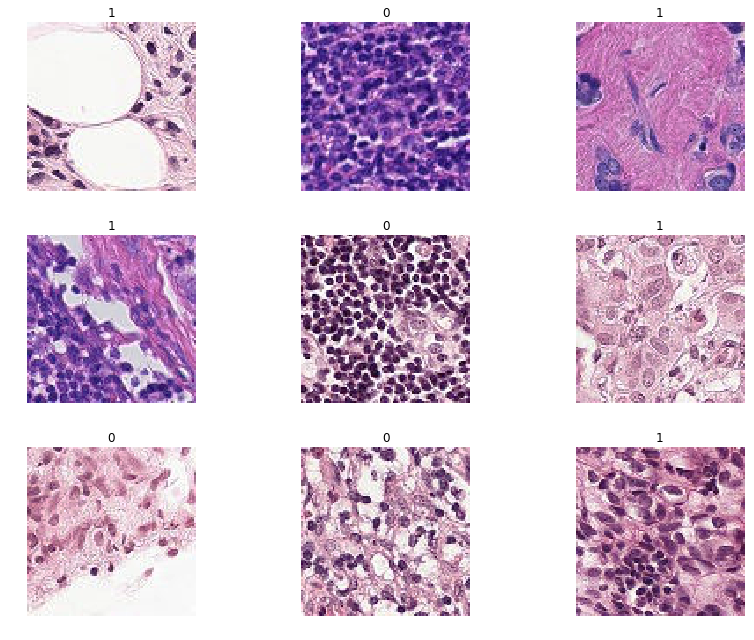

In [11]:
data.show_batch(rows=3, figsize=(12,9))

Defining the metric that is used in the competition as well as the loss function

In [12]:
from sklearn.metrics import roc_auc_score
def auc_score(y_pred,y_true):  
    return roc_auc_score(to_np(y_true),to_np(F.sigmoid(y_pred))[:,1])

In [13]:
#f1=Fbeta_binary(beta2=1)
f1=partial(fbeta,beta=1)

## Define a custom head for the gCNN
The original resnet has al ot more categories than 2 so a new head is needed.
The fastai package already delivers an awesome function for this. I had to define 2 little functions to adapt it to the group equivariant, namely make the pooling 3D not 2D

In [14]:
class AdaptiveConcatPool3d(nn.Module):
    "Layer that concats `AdaptiveAvgPool3d` and `AdaptiveMaxPool3d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        sz = sz or 1
        self.ap,self.mp = nn.AdaptiveAvgPool3d(sz), nn.AdaptiveMaxPool3d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [15]:
def create_head_custom(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, bn_final:bool=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = [AdaptiveConcatPool3d(), Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns):
        layers += bn_drop_lin(ni,no,True,p,actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)


## Now the data and model are merged in the fastai learner object
Since pretrained is set to False the network is unfrozen so we dont need a warm up period where we only train the head of the network

In [16]:
learn = create_cnn(
    data,
    ResNet18,
    path='.',    
    metrics=[fbeta], 
    ps=0.5,
    pretrained=False
)

## Now add the custom head

In [17]:
learn.model[1]=create_head_custom(362,2)
learn.model.to(learn.data.device)
print(learn.summary())


Layer (type)         Output Shape         Param #    Trainable 
P4MConvZ2            [16, 23, 8, 96, 96]  621        True      
______________________________________________________________________
BatchNorm3d          [16, 23, 8, 96, 96]  46         True      
______________________________________________________________________
P4MConvP4M           [16, 23, 8, 96, 96]  38088      True      
______________________________________________________________________
BatchNorm3d          [16, 23, 8, 96, 96]  46         True      
______________________________________________________________________
P4MConvP4M           [16, 23, 8, 96, 96]  38088      True      
______________________________________________________________________
BatchNorm3d          [16, 23, 8, 96, 96]  46         True      
______________________________________________________________________
Sequential           [16, 23, 8, 96, 96]  0          False     
______________________________________________________________

## And check for an appropriate learning rate
The maximum learning rate should be somewhere before the divergence/minimum and the minimum of the learning rate about a 10th of the maximum

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


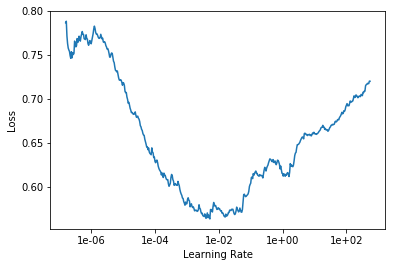

In [18]:
learn.lr_find(num_it=500,end_lr=1000)
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(1,slice(5e-2,1.5e-1))


epoch,train_loss,valid_loss,fbeta


In [20]:
learn.save('gCNN_1cycle')

Theres an error I don't understand yet in plot_loss() when only doing one epoch (I think)

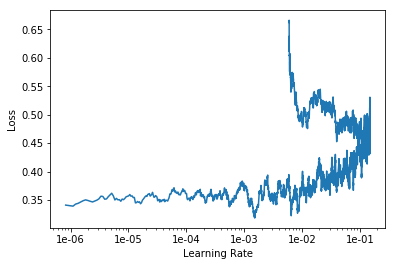

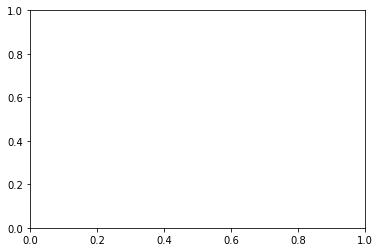

In [21]:
learn.recorder.plot()
try:
    learn.recorder.plot_losses()
    learn.recorder.plot_lr()
except:
    pass

## Check how well gCNN are doing
Now that we learned a lot we check how well we are doing by predicting on the validation set.
For just one epoch this is pretty good!
I achieved a LB score >0.96 with this, without TTA.

In [22]:
preds,y=learn.get_preds()
pred_score=auc_score(preds,y)
pred_score

0.9482866730111711

### Now predict on test set

In [23]:
preds_test,y_test=learn.get_preds(ds_type=DatasetType.Test)

In [24]:
preds_test_tta,y_test_tta=learn.TTA(ds_type=DatasetType.Test)

### prepare submission
I now load in the sample submission and put my predictions in the label column and save to a new file.

Sometimes its important in which order the ids in the submissions are so to make sure I don't mess up I put them in the same order. My first submission had a 50% score so I somewhere messed up the order oder the matching of id to label.
since fname_clean is the id we can just use that as index when adding the correct label in our dataframe. 

In [25]:
sub=pd.read_csv(f'{path}/sample_submission.csv').set_index('id')
sub.head()

,label
id,
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
2c35657e312966e9294eac6841726ff3a748febf,0
145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [26]:
clean_fname=np.vectorize(lambda fname: str(fname).split('/')[-1].split('.')[0])
fname_cleaned=clean_fname(data.test_ds.items)
fname_cleaned=fname_cleaned.astype(str)

## I add the score to the name of the file so I can later plot the leaderboard score versus my validation score
In the fastai course Jeremy mentions that if you have a monotonic relation between validation and LB score the way you set up your validation set matches what the test set consists of.

In [27]:
sub.loc[fname_cleaned,'label']=to_np(preds_test[:,1])
sub.to_csv(f'submission_{pred_score}.csv')

In [28]:
sub.loc[fname_cleaned,'label']=to_np(preds_test_tta[:,1])
sub.to_csv(f'submission_TTA_{pred_score}.csv')

In [29]:
!rm -r GrouPy/